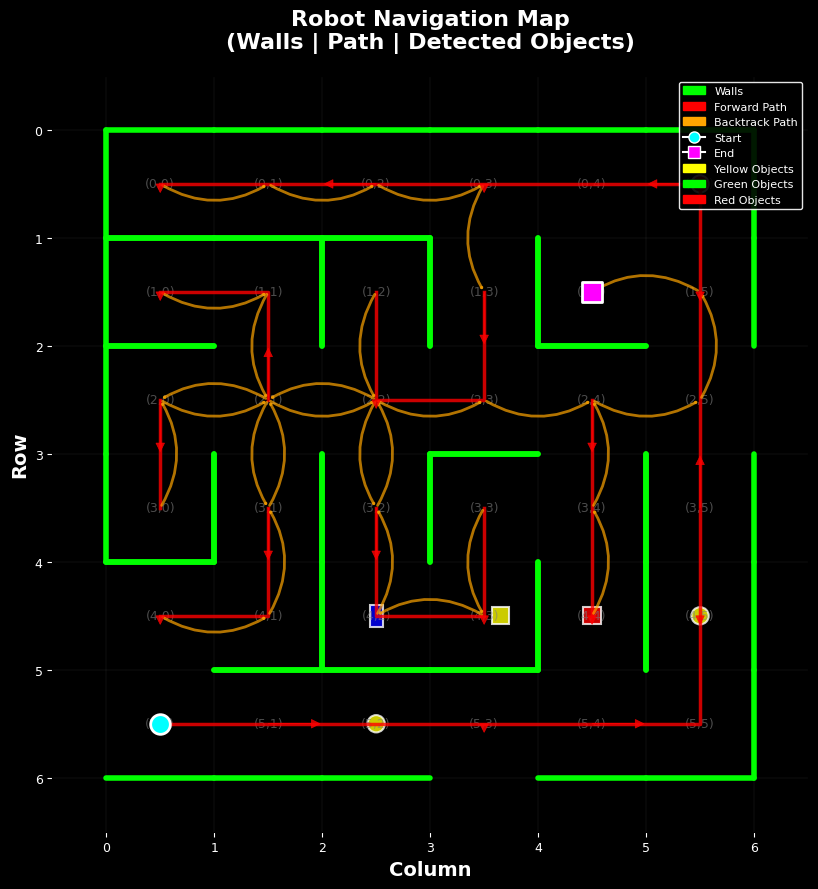


📊 NAVIGATION STATISTICS
Grid Size: 6x6
Total Positions Logged: 111
Total Objects Detected: 10

Start Time: 2025-10-07 01:35:19
End Time: 2025-10-07 01:43:07
Total Duration: 0:07:48.383036
Start Position: [5, 0]
End Position: [1, 4]
Session Status: ⚠️ INTERRUPTED

Backtrack Actions: 44

🎯 DETECTED OBJECTS:
   By Color: {'Red': 4, 'Blue': 3, 'Yellow': 3}
   By Shape: {'Circle': 3, 'Uncertain': 2, 'Rectangle_H': 2, 'Rectangle_V': 1, 'Square': 2}



In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch
import numpy as np
from datetime import datetime

# ==================== ตัวแปรสำหรับ Path ไฟล์ ====================
MAPPING_FILE = "Mapping_Top.json"
ROBOT_PATH_FILE = "Robot_Position_Timestamps.json"
DETECTED_OBJECTS_FILE = "Detected_Objects.json"
# =================================================================

def plot_comprehensive_map():
    """
    แสดงแผนที่แบบครบถ้วน: กำแพง + เส้นทางหุ่นยนต์ + วัตถุที่ตรวจพบ
    """
    # อ่านไฟล์ทั้ง 3
    with open(MAPPING_FILE, 'r', encoding='utf-8') as f:
        map_data = json.load(f)
    
    with open(ROBOT_PATH_FILE, 'r', encoding='utf-8') as f:
        robot_data = json.load(f)
    
    with open(DETECTED_OBJECTS_FILE, 'r', encoding='utf-8') as f:
        objects_data = json.load(f)
    
    nodes = map_data['nodes']
    position_log = robot_data['position_log']
    detected_objects = objects_data['detected_objects']
    
    # หาขนาดกริด
    max_row = max(node['coordinate']['row'] for node in nodes)
    max_col = max(node['coordinate']['col'] for node in nodes)
    grid_height = max_row + 1
    grid_width = max_col + 1
    
    # สร้างกราฟ
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.set_xlim(-0.5, grid_width + 0.5)
    ax.set_ylim(-0.5, grid_height + 0.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')
    
    # ========== 1. วาดกำแพง ==========
    for node in nodes:
        row = node['coordinate']['row']
        col = node['coordinate']['col']
        walls = node['walls']
        
        if walls['north']:
            ax.plot([col, col + 1], [row, row], 'lime', linewidth=4, solid_capstyle='round')
        if walls['south']:
            ax.plot([col, col + 1], [row + 1, row + 1], 'lime', linewidth=4, solid_capstyle='round')
        if walls['east']:
            ax.plot([col + 1, col + 1], [row, row + 1], 'lime', linewidth=4, solid_capstyle='round')
        if walls['west']:
            ax.plot([col, col], [row, row + 1], 'lime', linewidth=4, solid_capstyle='round')
        
        # แสดงพิกัด
        ax.text(col + 0.5, row + 0.5, f'({row},{col})', 
                ha='center', va='center', color='gray', fontsize=9, alpha=0.6)
    
    # ========== 2. วาดวัตถุที่ตรวจพบ ==========
    # จัดกลุ่มวัตถุตาม cell_position
    objects_by_cell = {}
    for obj in detected_objects:
        row = obj['cell_position']['row']
        col = obj['cell_position']['col']
        key = (row, col)
        if key not in objects_by_cell:
            objects_by_cell[key] = []
        objects_by_cell[key].append(obj)
    
    # วาดวัตถุ
    for (row, col), objs in objects_by_cell.items():
        num_objs = len(objs)
        
        # คำนวณตำแหน่งสำหรับวัตถุหลายชิ้น
        if num_objs == 1:
            positions = [(col + 0.5, row + 0.5)]
        elif num_objs == 2:
            positions = [(col + 0.35, row + 0.5), (col + 0.65, row + 0.5)]
        elif num_objs == 3:
            positions = [(col + 0.3, row + 0.5), (col + 0.5, row + 0.5), (col + 0.7, row + 0.5)]
        else:  # 4 หรือมากกว่า
            positions = [(col + 0.3, row + 0.35), (col + 0.7, row + 0.35),
                        (col + 0.3, row + 0.65), (col + 0.7, row + 0.65)]
        
        for i, obj in enumerate(objs[:len(positions)]):
            x, y = positions[i]
            color = obj['color'].lower()
            shape = obj['shape']
            
            # แปลงสีให้เป็นค่าที่ matplotlib รู้จัก
            if color == 'yellow':
                mpl_color = 'yellow'
            elif color == 'green':
                mpl_color = 'lime'
            elif color == 'red':
                mpl_color = 'red'
            elif color == 'blue':
                mpl_color = 'blue'
            else:
                mpl_color = 'white'
            
            # วาดรูปร่างตามประเภท
            if shape == 'Square':
                square = mpatches.Rectangle((x - 0.08, y - 0.08), 0.16, 0.16,
                                            facecolor=mpl_color, edgecolor='white',
                                            linewidth=1.5, alpha=0.8)
                ax.add_patch(square)
            elif shape == 'Rectangle_V':  # แนวตั้ง
                rect = mpatches.Rectangle((x - 0.06, y - 0.1), 0.12, 0.2,
                                        facecolor=mpl_color, edgecolor='white',
                                        linewidth=1.5, alpha=0.8)
                ax.add_patch(rect)
            elif shape == 'Circle':
                circle = mpatches.Circle((x, y), 0.08,
                                        facecolor=mpl_color, edgecolor='white',
                                        linewidth=1.5, alpha=0.8)
                ax.add_patch(circle)
    
    # ========== 3. วาดเส้นทางหุ่นยนต์ ==========
    if position_log:
        # แยกเส้นทาง: forward และ backtrack
        forward_segments = []
        backtrack_segments = []
        
        current_segment = []
        is_backtracking = False
        
        for i, log in enumerate(position_log):
            pos = (log['position'][1] + 0.5, log['position'][0] + 0.5)
            action = log['action']
            
            # ตรวจสอบว่าเป็น backtrack หรือไม่
            if 'Backtrack' in action:
                if not is_backtracking and current_segment:
                    forward_segments.append(current_segment)
                    current_segment = [pos]
                    is_backtracking = True
                else:
                    current_segment.append(pos)
            else:
                if is_backtracking and current_segment:
                    backtrack_segments.append(current_segment)
                    current_segment = [pos]
                    is_backtracking = False
                else:
                    current_segment.append(pos)
        
        # เพิ่ม segment สุดท้าย
        if current_segment:
            if is_backtracking:
                backtrack_segments.append(current_segment)
            else:
                forward_segments.append(current_segment)
        
        # วาดเส้นทาง forward (เส้นตรง)
        for segment in forward_segments:
            if len(segment) >= 2:
                x_coords = [p[0] for p in segment]
                y_coords = [p[1] for p in segment]
                ax.plot(x_coords, y_coords, 'red', linewidth=2.5, alpha=0.8, zorder=3)
                
                # เพิ่มลูกศรเล็กๆ
                for i in range(len(segment) - 1):
                    if i % 3 == 0:  # ใส่ลูกศรทุกๆ 3 segment
                        dx = segment[i+1][0] - segment[i][0]
                        dy = segment[i+1][1] - segment[i][1]
                        ax.arrow(segment[i][0], segment[i][1], dx*0.4, dy*0.4,
                                head_width=0.08, head_length=0.08, fc='red', 
                                ec='red', alpha=0.8, zorder=4, linewidth=0.5)
        
        # วาดเส้นทาง backtrack (เส้นโค้ง)
        for segment in backtrack_segments:
            if len(segment) >= 2:
                x_coords = [p[0] for p in segment]
                y_coords = [p[1] for p in segment]
                
                # วาดเส้นโค้งด้วย connectionstyle
                for i in range(len(segment) - 1):
                    arrow = FancyArrowPatch(
                        (x_coords[i], y_coords[i]),
                        (x_coords[i+1], y_coords[i+1]),
                        connectionstyle="arc3,rad=0.3",  # เส้นโค้ง
                        arrowstyle='->,head_width=0.3,head_length=0.3',
                        color='orange',
                        linewidth=2,
                        alpha=0.7,
                        zorder=3
                    )
                    ax.add_patch(arrow)
        
        # วาดจุดเริ่มต้นและจุดสิ้นสุด
        start_pos = (position_log[0]['position'][1] + 0.5, position_log[0]['position'][0] + 0.5)
        end_pos = (position_log[-1]['position'][1] + 0.5, position_log[-1]['position'][0] + 0.5)
        
        ax.scatter(start_pos[0], start_pos[1], color='cyan', s=200, marker='o', 
                edgecolors='white', linewidths=2, label='Start', zorder=5)
        ax.scatter(end_pos[0], end_pos[1], color='magenta', s=200, marker='s', 
                edgecolors='white', linewidths=2, label='End', zorder=5)
    
    # ========== 4. ตกแต่งกราฟ ==========
    ax.set_xticks(range(grid_width + 1))
    ax.set_yticks(range(grid_height + 1))
    ax.grid(True, color='white', linewidth=0.3, alpha=0.15, linestyle='-')
    ax.set_axisbelow(True)
    
    ax.set_xlabel('Column', color='white', fontsize=14, fontweight='bold')
    ax.set_ylabel('Row', color='white', fontsize=14, fontweight='bold')
    ax.set_title('Robot Navigation Map\n(Walls | Path | Detected Objects)', 
                color='white', fontsize=16, fontweight='bold', pad=20)
    ax.tick_params(colors='white', labelsize=9)
    
    # Legend
    legend_elements = [
        mpatches.Patch(color='lime', label='Walls'),
        mpatches.Patch(color='red', label='Forward Path'),
        mpatches.Patch(color='orange', label='Backtrack Path'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', 
                markersize=8, label='Start'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='magenta', 
                markersize=8, label='End'),
        mpatches.Patch(color='yellow', label='Yellow Objects'),
        mpatches.Patch(color='lime', label='Green Objects'),
        mpatches.Patch(color='red', label='Red Objects')
    ]
    ax.legend(handles=legend_elements, loc='upper right', 
            facecolor='black', edgecolor='white', fontsize=8,
            labelcolor='white', framealpha=0.9)
    
    plt.tight_layout()
    plt.show()
    
    # ========== 5. แสดงสถิติ ==========
    print("\n" + "="*60)
    print("📊 NAVIGATION STATISTICS")
    print("="*60)
    print(f"Grid Size: {grid_height}x{grid_width}")
    print(f"Total Positions Logged: {len(position_log)}")
    print(f"Total Objects Detected: {len(detected_objects)}")
    
    if position_log:
        start_time = datetime.fromisoformat(position_log[0]['iso_timestamp'].replace('Z', '+00:00'))
        end_time = datetime.fromisoformat(position_log[-1]['iso_timestamp'].replace('Z', '+00:00'))
        duration = end_time - start_time
        
        print(f"\nStart Time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"End Time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Total Duration: {duration}")
        print(f"Start Position: {position_log[0]['position']}")
        print(f"End Position: {position_log[-1]['position']}")
        print(f"Session Status: {'⚠️ INTERRUPTED' if robot_data['session_info']['interrupted'] else '✅ COMPLETED'}")
    
    # นับจำนวน backtrack
    backtrack_count = sum(1 for log in position_log if 'Backtrack' in log['action'])
    print(f"\nBacktrack Actions: {backtrack_count}")
    
    # สรุปวัตถุ
    print(f"\n🎯 DETECTED OBJECTS:")
    color_counts = {}
    shape_counts = {}
    for obj in detected_objects:
        color = obj['color']
        shape = obj['shape']
        color_counts[color] = color_counts.get(color, 0) + 1
        shape_counts[shape] = shape_counts.get(shape, 0) + 1
    
    print(f"   By Color: {dict(color_counts)}")
    print(f"   By Shape: {dict(shape_counts)}")
    print("="*60 + "\n")


# ==================== เรียกใช้งาน ====================
if __name__ == "__main__":
    plot_comprehensive_map()

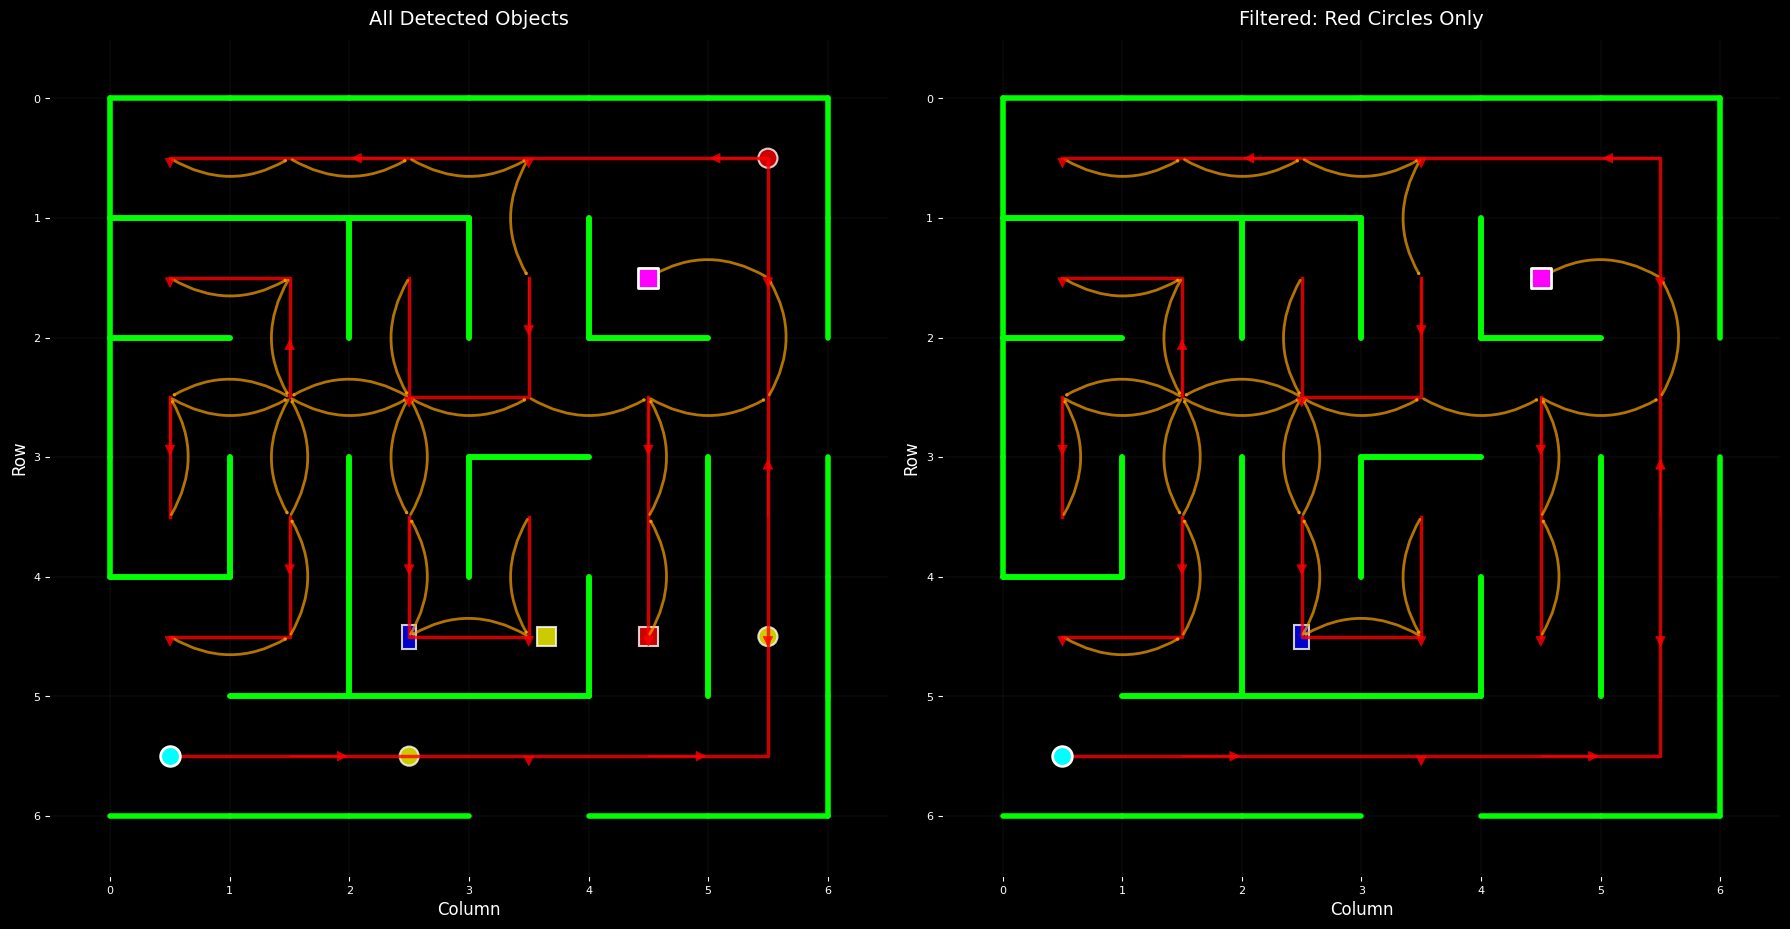

In [3]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch
from datetime import datetime

# ==================== ตัวแปรสำหรับ Path ไฟล์ ====================
MAPPING_FILE = "Mapping_Top.json"
ROBOT_PATH_FILE = "Robot_Position_Timestamps.json"
DETECTED_OBJECTS_FILE = "Detected_Objects.json"
# =================================================================

def plot_comprehensive_map():
    """
    แสดง 2 แผนภาพ:
    - ซ้าย: แสดงทุกวัตถุที่ตรวจพบ
    - ขวา: แสดงเฉพาะวัตถุที่มี color=Red และ shape=Circle
    พร้อมเส้นทางหุ่นยนต์ กำแพง จุดเริ่ม–จุดจบ
    """
    # อ่านไฟล์ทั้ง 3
    with open(MAPPING_FILE, 'r', encoding='utf-8') as f:
        map_data = json.load(f)
    with open(ROBOT_PATH_FILE, 'r', encoding='utf-8') as f:
        robot_data = json.load(f)
    with open(DETECTED_OBJECTS_FILE, 'r', encoding='utf-8') as f:
        objects_data = json.load(f)

    nodes = map_data['nodes']
    position_log = robot_data['position_log']
    detected_objects = objects_data['detected_objects']

    # หาขนาดกริด
    max_row = max(node['coordinate']['row'] for node in nodes)
    max_col = max(node['coordinate']['col'] for node in nodes)
    grid_height = max_row + 1
    grid_width = max_col + 1

    # ================== สร้าง 2 figure เคียงกัน ==================
    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    titles = ["All Detected Objects", "Filtered: Red Circles Only"]

    for ax_i, ax in enumerate(axes):
        # ตั้งค่าพื้นหลัง
        ax.set_xlim(-0.5, grid_width + 0.5)
        ax.set_ylim(-0.5, grid_height + 0.5)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.set_facecolor('black')
        fig.patch.set_facecolor('black')

        # ========== 1. วาดกำแพง ==========
        for node in nodes:
            row = node['coordinate']['row']
            col = node['coordinate']['col']
            walls = node['walls']

            if walls['north']:
                ax.plot([col, col + 1], [row, row], 'lime', linewidth=4, solid_capstyle='round')
            if walls['south']:
                ax.plot([col, col + 1], [row + 1, row + 1], 'lime', linewidth=4, solid_capstyle='round')
            if walls['east']:
                ax.plot([col + 1, col + 1], [row, row + 1], 'lime', linewidth=4, solid_capstyle='round')
            if walls['west']:
                ax.plot([col, col], [row, row + 1], 'lime', linewidth=4, solid_capstyle='round')

        # ========== 2. วาดเส้นทางหุ่นยนต์ ==========
        if position_log:
            forward_segments = []
            backtrack_segments = []
            current_segment = []
            is_backtracking = False

            for i, log in enumerate(position_log):
                pos = (log['position'][1] + 0.5, log['position'][0] + 0.5)
                action = log['action']

                if 'Backtrack' in action:
                    if not is_backtracking and current_segment:
                        forward_segments.append(current_segment)
                        current_segment = [pos]
                        is_backtracking = True
                    else:
                        current_segment.append(pos)
                else:
                    if is_backtracking and current_segment:
                        backtrack_segments.append(current_segment)
                        current_segment = [pos]
                        is_backtracking = False
                    else:
                        current_segment.append(pos)

            if current_segment:
                if is_backtracking:
                    backtrack_segments.append(current_segment)
                else:
                    forward_segments.append(current_segment)

            # เส้นทาง forward
            for segment in forward_segments:
                if len(segment) >= 2:
                    x_coords = [p[0] for p in segment]
                    y_coords = [p[1] for p in segment]
                    ax.plot(x_coords, y_coords, 'red', linewidth=2.5, alpha=0.8, zorder=3)
                    for i in range(len(segment) - 1):
                        if i % 3 == 0:
                            dx = segment[i+1][0] - segment[i][0]
                            dy = segment[i+1][1] - segment[i][1]
                            ax.arrow(segment[i][0], segment[i][1], dx*0.4, dy*0.4,
                                    head_width=0.08, head_length=0.08, fc='red', ec='red',
                                    alpha=0.8, zorder=4, linewidth=0.5)

            # เส้นทาง backtrack
            for segment in backtrack_segments:
                if len(segment) >= 2:
                    x_coords = [p[0] for p in segment]
                    y_coords = [p[1] for p in segment]
                    for i in range(len(segment) - 1):
                        arrow = FancyArrowPatch(
                            (x_coords[i], y_coords[i]),
                            (x_coords[i+1], y_coords[i+1]),
                            connectionstyle="arc3,rad=0.3",
                            arrowstyle='->,head_width=0.3,head_length=0.3',
                            color='orange',
                            linewidth=2,
                            alpha=0.7,
                            zorder=3
                        )
                        ax.add_patch(arrow)

            # จุดเริ่ม–จุดสิ้นสุด
            start_pos = (position_log[0]['position'][1] + 0.5, position_log[0]['position'][0] + 0.5)
            end_pos = (position_log[-1]['position'][1] + 0.5, position_log[-1]['position'][0] + 0.5)

            ax.scatter(start_pos[0], start_pos[1], color='cyan', s=200, marker='o',
                    edgecolors='white', linewidths=2, label='Start', zorder=5)
            ax.scatter(end_pos[0], end_pos[1], color='magenta', s=200, marker='s',
                    edgecolors='white', linewidths=2, label='End', zorder=5)

        # ========== 3. วาดวัตถุ ==========
        if ax_i == 0:
            objs_to_draw = detected_objects
        else:
            objs_to_draw = [
                o for o in detected_objects
                if o['color'].lower() == 'blue' and o['shape'] == 'Rectangle_V'
            ]

        # จัดกลุ่มตาม cell
        objects_by_cell = {}
        for obj in objs_to_draw:
            row = obj['cell_position']['row']
            col = obj['cell_position']['col']
            key = (row, col)
            if key not in objects_by_cell:
                objects_by_cell[key] = []
            objects_by_cell[key].append(obj)

        for (row, col), objs in objects_by_cell.items():
            num_objs = len(objs)
            if num_objs == 1:
                positions = [(col + 0.5, row + 0.5)]
            elif num_objs == 2:
                positions = [(col + 0.35, row + 0.5), (col + 0.65, row + 0.5)]
            elif num_objs == 3:
                positions = [(col + 0.3, row + 0.5), (col + 0.5, row + 0.5), (col + 0.7, row + 0.5)]
            else:
                positions = [(col + 0.3, row + 0.35), (col + 0.7, row + 0.35),
                            (col + 0.3, row + 0.65), (col + 0.7, row + 0.65)]

            for i, obj in enumerate(objs[:len(positions)]):
                x, y = positions[i]
                color = obj['color'].lower()
                shape = obj['shape']

                if color == 'yellow':
                    mpl_color = 'yellow'
                elif color == 'green':
                    mpl_color = 'lime'
                elif color == 'red':
                    mpl_color = 'red'
                elif color == 'blue':
                    mpl_color = 'blue'
                else:
                    mpl_color = 'white'

                if shape == 'Square':
                    ax.add_patch(mpatches.Rectangle((x - 0.08, y - 0.08), 0.16, 0.16,
                                                    facecolor=mpl_color, edgecolor='white',
                                                    linewidth=1.5, alpha=0.8))
                elif shape == 'Rectangle_V':
                    ax.add_patch(mpatches.Rectangle((x - 0.06, y - 0.1), 0.12, 0.2,
                                                    facecolor=mpl_color, edgecolor='white',
                                                    linewidth=1.5, alpha=0.8))
                elif shape == 'Circle':
                    ax.add_patch(mpatches.Circle((x, y), 0.08,
                                                facecolor=mpl_color, edgecolor='white',
                                                linewidth=1.5, alpha=0.8))

        # ========== 4. ตกแต่ง ==========
        ax.set_xticks(range(grid_width + 1))
        ax.set_yticks(range(grid_height + 1))
        ax.grid(True, color='white', linewidth=0.3, alpha=0.15)
        ax.tick_params(colors='white', labelsize=8)
        ax.set_title(titles[ax_i], color='white', fontsize=14, pad=10)
        ax.set_xlabel('Column', color='white', fontsize=12)
        ax.set_ylabel('Row', color='white', fontsize=12)

    plt.tight_layout()
    plt.show()


# ==================== เรียกใช้งาน ====================
if __name__ == "__main__":
    plot_comprehensive_map()
